In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


# change settings for plots
plt.style.use('fivethirtyeight')

In [4]:
# write plotting functions to be used later



# 1) Load and Clean Data

In [5]:
data = pd.read_csv('/Users/alitaimurshabbir/Desktop/cfpb-consumer-complaints/data/complaint_data.csv')

## Find and deal with missing data

In [30]:
# number of cells missing as percentage of total cells

missing_percent = round((data.isnull().sum().sum()/np.product(data.shape))*100)
print('The proportion of missing data on a cell-by-cell basis is {}%'.format(missing_percent))

The proportion of missing data on a cell-by-cell basis is 21%


(0.0, 1300000.0)

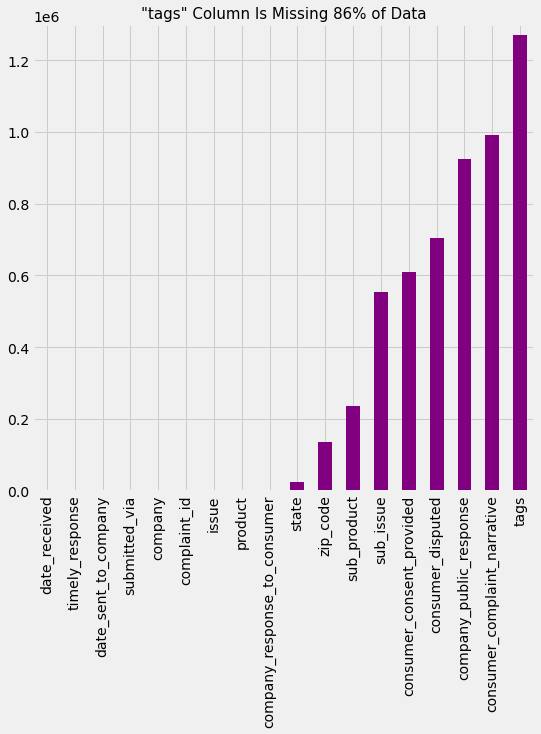

In [43]:
# absolute number of cells missing from data per column

plt.figure(figsize = (8, 8))
data.isnull().sum().sort_values().plot(kind = 'bar', color = 'purple')
plt.title('"tags" Column Is Missing 86% of Data', size = 15)
plt.ylim([0, 1300000])

"tags" has the greatest number of cells missing (1,271,201 cells) followed by "consumer_complaint_narrative" (990,679 cells) and "company_public_response" (923,665 cells)

If we take a look at the values of "tags", we see that it relates to the demographic and military background of a customer (see below). We'll keep this data for now to understand more about our customers at a later stage.

More broadly, I am going to follow this approach for the whole dataset. In my judgement it doesn't make sense to drop any missing values d

In [35]:
data.tags.value_counts()

Servicemember                    99855
Older American                   84371
Older American, Servicemember    16339
Name: tags, dtype: int64

Next, looking at "company_public_response" shows us some standard responses by the Company in each case of customer complaints. We'll keep these records for the same purpose as above

In [45]:
data.company_public_response.value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            399111
Company believes it acted appropriately as authorized by contract or law                                                    70164
Company chooses not to provide a public response                                                                            52473
Company believes the complaint is the result of a misunderstanding                                                           6425
Company disputes the facts presented in the complaint                                                                        5793
Company believes complaint caused principally by actions of third party outside the control or direction of the company      4343
Company believes complaint is the result of an isolated error                                                                4232
Company believes complaint represents an opportunity for improvement to better serve consu

Text(0, 0.5, 'Did the Customer Dispute?')

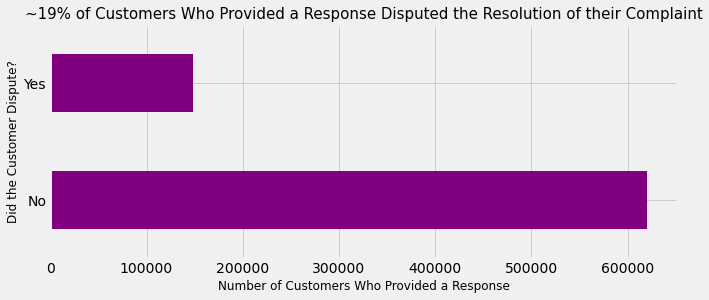

In [64]:
# "consumer_disputed" column and values

plt.figure(figsize = (10, 4))
data.consumer_disputed.value_counts().plot(kind = 'barh', color = 'purple')
plt.title('~19% of Customers Who Provided a Response Disputed the Resolution of their Complaint', size = 15)
plt.xlabel('Number of Customers Who Provided a Response', size = 12)
plt.ylabel('Did the Customer Dispute?', size = 12)

# 1) Load and Clean Data

In [4]:
data = pd.read_csv('/Users/alitaimurshabbir/Desktop/CRM Analytics Datasets/marketing_campaign.csv', sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## 1.1) Description of Columns

- AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise

- AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

- AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

- AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise

- AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise

- Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise

- Complain - 1 if customer complained in the last 2 years

- DtCustomer - date of customer’s enrolment with the company

- Education - customer’s level of education

- Marital - customer’s marital status

- Kidhome - number of small children in customer’s household

- Teenhome - number of teenagers in customer’s household

- Income - customer’s yearly household income

- MntFishProducts - amount spent on fish products in the last 2 years

- MntMeatProducts - amount spent on meat products in the last 2 years

- MntFruits - amount spent on fruits products in the last 2 years

- MntSweetProducts - amount spent on sweet products in the last 2 years

- MntWines - amount spent on wine products in the last 2 years

- MntGoldProds - amount spent on gold products in the last 2 years

- NumDealsPurchases - number of purchases made with discount

- NumCatalogPurchases - number of purchases made using catalogue

- NumStorePurchases - number of purchases made directly in stores

- NumWebPurchases - number of purchases made through company’s web site

- NumWebVisitsMonth - number of visits to company’s web site in the last month

- Recency - number of days since the last purchase

## 1.2) Check for Duplicates

In [5]:
sum(data['ID'].duplicated())

0

Using the unique identifier "ID", we find no duplicates

## 1.3) Find and deal with missing data

In [6]:
missing_percent = (data.isnull().sum().sum()/np.product(data.shape))*100
print('The proportion of missing data on a cell-by-cell basis is {}%'.format(missing_percent))

The proportion of missing data on a cell-by-cell basis is 0.03694581280788178%


The amount of data missing is miniscule. We can isolate which column has this missing data then drop those rows. This will not impact the quality of the dataset since, as stated, there's very few rows that are empty

In [7]:
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [8]:
# drop rows where "Income" is missing data

data = data[data['Income'].notna()]

## 1.4) Check for extreme values that could be erroneous

In [9]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000
mean,5588.353339,1968.820397,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,...,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,3.0,11.0,0.150271
std,3249.376275,11.985554,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,...,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.0,0.0,0.357417
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2814.750000,1959.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


There do not seem to be any obviously erroneous values. However, we see that the earliest year of birth in the data is 1893. This dataset is from 2020, making this particular customer 127 years old at the time of collection. Is this a valid record? It's possible but highly unlikely.

I will keep this record for now and, just for curiosity's sake, check how many customers are older than 90 years of age

In [10]:
# to be 90 years of age or more, a customer needs to be born in or before 1932 (2020-1930 = 90)

data[data['Year_Birth'] <= 1930]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,...,5,0,0,0,0,0,1,3,11,0
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,...,4,0,0,0,0,0,0,3,11,0
339,1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,...,1,0,0,1,0,0,0,3,11,0


# 2) Exploratory Data Analysis

## 2.1) Overall Conversion Rates (%), Cost Per Acquisition (CPA) and Profitability

We have a lot of data in terms of different variables. We even have conversion data from the last 5 Marketing Campaign (our most recent campaign is not included in this count. It is our target variable).

Segmenting and dissecting the data in every possible way will lead to an extremely long piece of analysis. Not all of the analysis will be valuable either. After all, we are only interested in insights that have the maximum business impact.

Therefore, to frame the analysis, I am going to restrict the scope to explore only the most recent Marketing Campaign. In addition, I will choose what I judge to be the most interesting and promising variables to explore insights.

### 2.11) Conversion Rate (%)

Text(0, 0.5, 'Response')

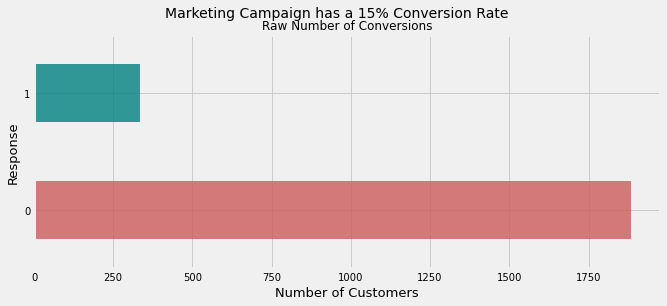

In [71]:
# find conversions

data.Response.value_counts().plot(kind = 'barh',
                                  color = ['indianred', 'teal'],
                                  figsize = (10, 4),
                                  alpha = 0.8)

plt.suptitle('Marketing Campaign has a 15% Conversion Rate', size = 14)
plt.title('Raw Number of Conversions', size = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Number of Customers', size = 13)
plt.ylabel('Response', size = 13)

### 2.12) Cost Per Acquisition (CPA) and Profitability

The data shows us that the cost to contact a single customer is fixed at $3. We can use this information to calculate how profitable our marketing campaign was

In [79]:
conditions = [data['Response'] == 1, data['Response'] == 0]
outcomes = [8, -8]

data['Profit'] = np.select(conditions, outcomes)

For now we can find a simple total for how profitable our campaign was. Later we will segment profitability by customer characteristics to figure out which of our customers were the most and least valuable

In [87]:
print('The total Profit (+) or Loss (-) of our marketing campaign was {} USD'.format(sum(data['Profit'])))

The total Profit (+) or Loss (-) of our marketing campaign was -12400 USD


Clearly, this marketing campaign was a failure, as the business lost $12,400.

Now one of our main aims is to figure out which customers, grouped by characteristics, caused us to lose money (so we reconsider marketing to them in the future) and which customers were profitable (so we can target them more narrowly next time)

## 2.2) Income

Next I want to find out how conversion and profitability vary with customer Income.

To be able to do this, I will examine the distribution of the Income variable and create appropriate bins, then plot these against the customer responses

Text(0, 0.5, 'Frequency')

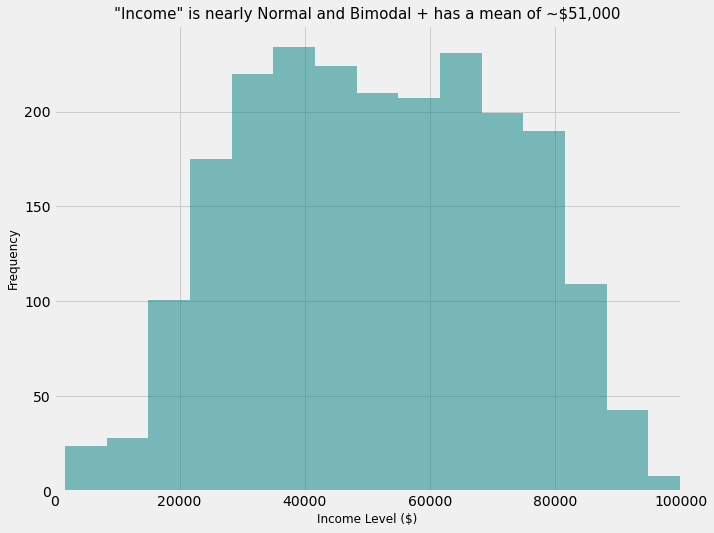

In [11]:
# create histogram of "Income"
# Restrict upper limit of "Income" to exclude entries above 100,000 for better
# visualisation. There are 13 such cases

plt.figure(figsize = (10, 8))
data['Income'].hist(bins = 100, color = 'teal', grid = True, alpha = 0.5)
plt.xlim([0, 100000])
plt.title('"Income" is nearly Normal and Bimodal + has a mean of ~$51,000', size = 15)
plt.xlabel('Income Level ($)', size = 12)
plt.ylabel('Frequency', size = 12)

Text(0, 0.5, 'Density')

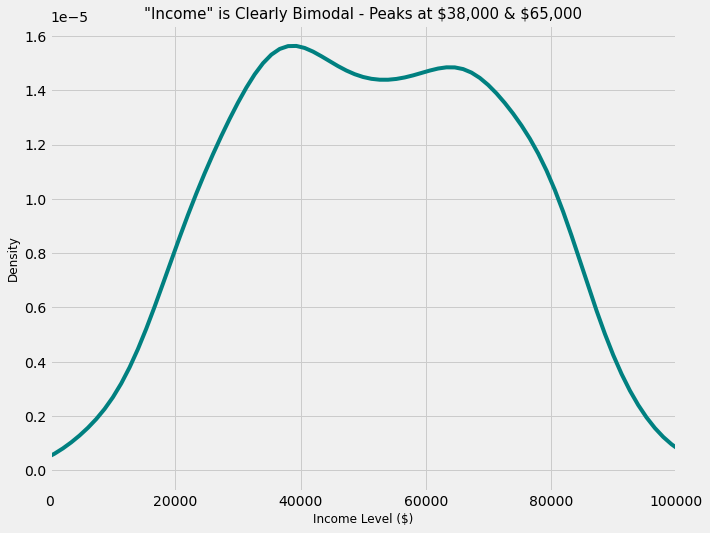

In [88]:
# Let's create a density plot for a smoother graph

plt.figure(figsize = (10, 8))
data['Income'].plot(kind = 'kde', color = 'teal')
plt.xlim([0, 100000])
plt.title('"Income" is Clearly Bimodal - Peaks at \$38,000 & \$65,000', size = 15)
plt.xlabel('Income Level ($)', size = 12)
plt.ylabel('Density', size = 12)

This confirms that the Income variable is Bimodal

### 2.21) Number of Customer Conversions by Income

In [13]:
# Create deciles - 10 bins with "Income" variable equally divided

data['Income Deciles'] = pd.qcut(data.Income, q = 10, precision = 0)

The following graph shows the raw number of customer conversions segmented by income deciles (10 bins of customers by income). 

We can clearly see that 

- The greatest number of conversions are isolated to the two highest income deciles


- The fewest number of customers which were targeted by the marketing campaign also belong to the above two deciles

Text(0, 0.5, 'Income Deciles ($) and Customer Response (1 = Yes | 0 = No)')

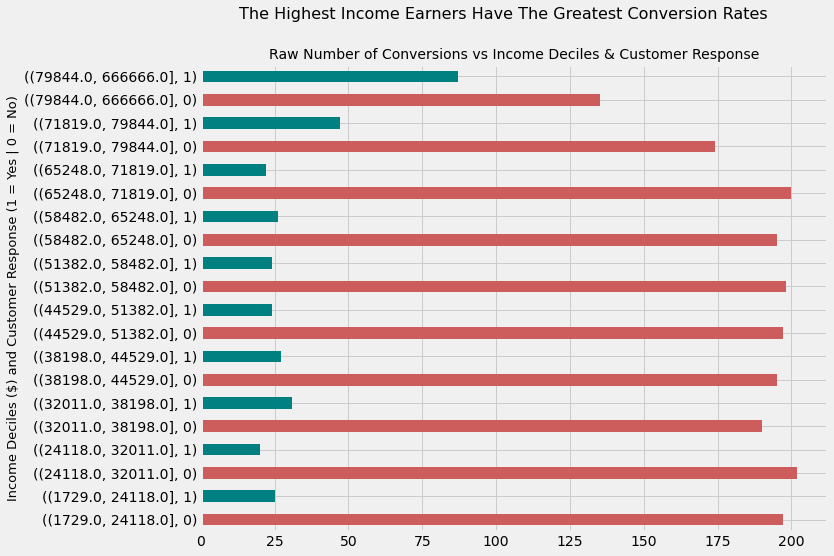

In [104]:
data.groupby('Income Deciles')['Response'].value_counts().plot(kind = 'barh',
                                                               color = ['indianred','teal'],
                                                               figsize = (10, 8))

plt.suptitle('The Highest Income Earners Have The Greatest Conversion Rates', size = 16)
plt.title('Raw Number of Conversions vs Income Deciles & Customer Response', size = 14)
plt.ylabel('Income Deciles ($) and Customer Response (1 = Yes | 0 = No)', size = 13)

### 2.22) Marketing Campaign Profitability by Income Deciles

<AxesSubplot:ylabel='Income Deciles'>

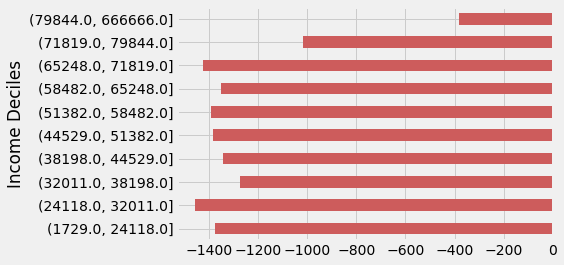

In [112]:
data.groupby('Income Deciles')['Profit'].sum().plot(kind = 'barh', color = 'indianred')

We have suffered losses in each and every single customer segment when segmented by Income level, with the 'lowest loss' occurring in the highest income decile segment (\\$79,844 to \\$666,666)

## 2.3) Age and Education

(20.0, 80.0)

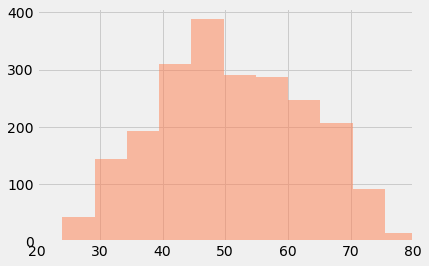

In [22]:
# Create "Age" variable

data['Age'] = 2020 - data['Year_Birth']
data['Age'].hist(bins = 20, color = 'coral', alpha = 0.5)
plt.xlim([20, 80])

In [31]:
# create Age bins. Youngest customer is 24 years old

data['Age Bins'] = pd.cut(data['Age'], bins = [24, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])

In [55]:
def age_vs_purchase(ad_campaign_number, plot_title):
    plt.figure(figsize = (15, 10))
    pd.crosstab(data['Age Bins'],
                data[ad_campaign_number]).plot(kind = 'barh',
                                               color = ['grey', 'coral'],
                                               figsize = (10, 6))
    plt.suptitle(plot_title, size = 14)
    plt.title('Raw Number of Customer Conversions per Age Band', size = 11)
    plt.legend(loc = 'lower right')
    plt.xlabel('Number of Customers', size = 10)
    plt.ylabel('Age Band', size = 10)
    plt.show()

<Figure size 1080x720 with 0 Axes>

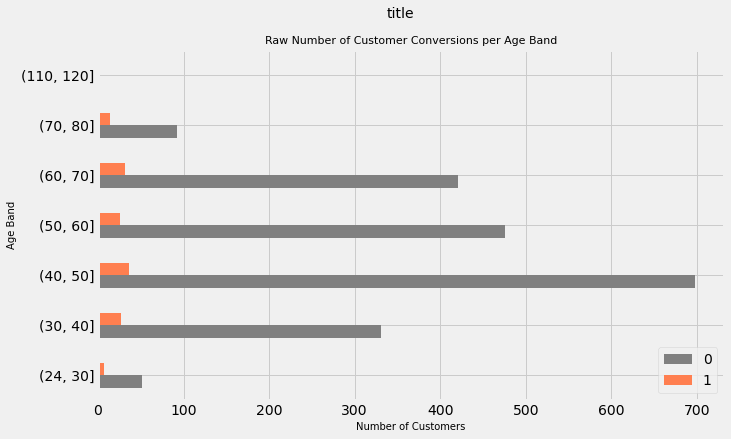

In [56]:
age_vs_purchase('AcceptedCmp1', 'title')